# Probability
#### Written by: Thomas Moerland, Leiden University

Probability is a vital part of all machine learning. When we deal with data we also continuously deal with uncertainty, since observations are stochastic/noisy and/or we have only seen a limited amount of data. Probability is therefore often used, for example in the form of:

- Output uncertainty (loss function): In supervised learning we often learn $p(y|x)$. We want to predict some $y$ given some observations $x$, but for a given $x$ we don't always observe the same $y$. Therefore, we model the conditional distribution of $y$ given $x$. You may, e.g., use a table, linear regression or neural network to store/estimate this distribution. The probability distribution is then often used to construct the loss function (e.g., maximum likelihood estimation).
- Model/parameter uncertainty (due to limited data): There often is additional uncertainty in the model due to the fact that we observed a limited amount of data. Even when we model $p(y|x)$, then this estimate will be more inaccurate the less data we have. We may therefore for example try to estimate $p(\theta|\mathcal{D})$, where $\theta$ are the parameters of our model, and $\mathcal{D}$ is our complete dataset, to quantify the uncertainty in our model.
- In reinforcement learning we define a policy $\pi(a|s)$ and transition function $p(s'|s,a)$ as conditional distributions, and the objective we try to maximize is actually an expectation/average over both (over multiple timesteps).


The goal of this notebook is to briefly summarize the key concepts in probability theory, which we need to deal with the above uncertainties. There are many textbooks on probability, but our goal here is to explicitly connect equations and code in a single document. This is hopefully - especially - useful to students who struggle with mathematical formulas, since you direct see an example of each equation (and you can play around with it yourself).

The structure of this notebook is shown below:

1. Discrete probability distributions
2. Continuous probability distributions
3. Sampling from a distribution
4. Distributions over multiple variables: joint, marginal, & conditional distributions
5. Expectation
6. Variance
7. Entropy
8. Predicting a distribution with a neural network

We will first define probability distributions for both the **discrete** (Sec. 1) and **continuous** case (Sec. 2). Then, we will discuss various important properties of probability distributions (Sec. 3-8), but mostly for the discrete case, since this setting is the easiest to understand. However, all concepts are equally applicable to (and relevant for) the continuous case, but most of the times summation over a discrete space just gets replaced with integration over a continuous space.

# 1. Discrete probability distributions

We can define a variable in a computer, such as ```x=2```. However, for many variables in the real world we don't know yet what the value will be. It might become ```x=2```, but it could also be ```x=1``` or ```x=0```. We call such variables, whose outcomes has some uncertain, a **random variable** (RV).

This feels strange to most computer scientist, since how do we store such a random variable in a computer? The answer to this question are **probability distributions**, which store all possible values a variable might take and their associated probability.

There are some notational conventions for probability distributions (which will become clear further below):

- Sample space ($\mathcal{X}$, italic capitalized for sets): what values can our uncertain variable possibly take? For example, for a dice throw the sample space is $\mathcal{X} = \{1,2,3,4,5,6\}$.

- Variable realisation ($x$, lower case for an individual element): a particular element of the sample space, i.e., a value that the random variable might take. For example, $x=3$ indicates we throw a '3' with the dice.

- Random variable ($X$, upper case for a random variable): a variable of which we do not know yet which value it takes. For example, $X$ may denote the (still uncertain) number we throw with the dice.

- Probability density function ($p(X=x)$, with $p$ for probability): the probability that the random variable $X$ takes a specific value $x$. For example, $p(X=3)=1/6$ indicates that the probability that we throw '3' with a fair dice is $1/6$. We often abbreviate the probability density function (pdf) to $p(x)$ or $p(X)$.

Let's formally introduce these concepts below, with code examples.




## Sample space

The sample space, for which we typically write an uppercase italic letter such as $\mathcal{X}$, is the set of possible values our random variable $X$ might take. We will first focus on discrete sample spaces, for example:

- For a dice roll the sample space is `{1,2,3,4,5,6}`.
- For a football match the possible obtainable number of points are `{0,1,3}` for a loss, draw and win, respectively.
- For a lottery ticket you may either win or lose, i.e., `{win, lose}`, which we often encode as `{0,1}` in a computer. We call a 0/1 variable a **binary** or **Bernouilli** variable.
- For an image classification task the outcome might be from `{cat,dog,rabbit}`, which we may encode as `{0,1,2}` in a computer.  

### Categorical versus Ordinal
Note the difference between the top two and bottom two examples:
- Ordinal:
  - The dice roll and football match points are examples of *ordinal* discrete variables. The values in the sample space of such variable have a numerical ordering/relation. For example, throwing a 6 is worth twice as much as throwing a 3.
- Categorical:
  - The bottom two are examples of *categorical* discrete variables. For categorical distributions the elements in the sample space are completely disjoint. For example, we may encode `{cat,dog,rabbit}` as `{0,1,2}`, but that of course does not mean a rabbit is worth two dogs.
  - One-hot encoding: Categorical variables, where the elements are disjoint categories, should actually be thought of as **one-hot encoded** variables. In the example of the `{cat,dog,rabbit}` sample space, we really have three binary variables, indicating whether a cat, dog or rabbit is present. We may use `cat = [1,0,0]`, `dog = [0,1,0]` and `rabbit = [0,0,1]`. For simplicity, we may encode these as `0`, `1` and `2` in our computer, but always remember whether the variable is ordinal or actually categorical.

In [ ]:
import numpy as np
x_dice_roll = np.array([1,2,3,4,5,6])
x_football_match_points = np.array([0,1,3])
print("Ordinal sample spaces")
print('Dice roll: ', x_dice_roll)
print('Football match points: ', x_football_match_points)

x_lottery_win = np.array([0,1])
x_image_classification = ('cat','dog','rabbit')
x_image_classification_index = np.array([0,1,2])
x_image_classification_one_hot = np.array([[1,0,0],[0,1,0],[0,0,1]])
print("\nCategorical sample spaces")
print('Lottery win: ', x_lottery_win)
print('Image classification: ', x_image_classification)
print('Image classification (to index): ', x_image_classification_index)
print('Image classification (to one-hot): ', x_image_classification_one_hot)


Ordinal sample spaces
Dice roll:  [1 2 3 4 5 6]
Football match points:  [0 1 3]

Categorical sample spaces
Lottery win:  [0 1]
Image classification:  ('cat', 'dog', 'rabbit')
Image classification (to index):  [0 1 2]
Image classification (to one-hot):  [[1 0 0]
 [0 1 0]
 [0 0 1]]


## Probability mass function (pmf)
We now defined the possible values our random variable might take, but we still need to describe the probability of each possible option. This is done through a **probability mass function (pmf)**, also called the **discrete probability density function** (pdf). For discrete variables this a function that maps every element from the sample space to a number in $[0,1]$, representing the chance that we get that observation. We write $p(X=x)$ to denote this probability, i.e., the chance that random variable $X$ takes a certain value $x$ from the sample space. Note that we often abbreviate $p(X=x)$ to either $p(X)$ or $p(x)$.

For example, if $X$ denotes the random variable for the number of points we get from a football match, and the chance that we will win and get 3 points is 50%, then we would write:

$$p(X=3) = 0.5$$

Crucially, to make this a valid probability distribution we need to ensure that **all probabities over the whole sample space add up to 1.0**, i.e.:

$$ \sum_{x \in \mathcal{X}} p(x) = 1.0 $$

Below we define a distribution for the points in a football match, if we have 20% chance of losing (0 points), 30% of a draw (1 point), and 50% of a win. We also verify that the distribution sums to 1.0.

In [ ]:
p_x = [0.2, 0.3, 0.5]
print('Sample space x = ',x_football_match_points )
print('pmf p(x)=', p_x)
assert np.sum(p_x) == 1.0 # Distribution sums up to 1.0


Sample space x =  [0 1 3]
pmf p(x)= [0.2, 0.3, 0.5]


## Cumulative distribution function (cdf)

Another important function is the **cumulative distribution function** (cdf), which is essentially a summed version of the above probability mass function (pmf). While the pmf provides the probability that the discrete random variable $X$ is exactly equal to $x$, the cdf provide the probability that the discrete random variable is smaller or equal than a certain value $x$. In equations:

$$ cdf(x) = p(X \leq x) $$

Let's compute the cdf of our football match points distribution:  

In [ ]:
cdf_x = np.cumsum(p_x)
print('Sample space x= ',x_football_match_points )
print('cdf =', cdf_x)

Sample space x=  [0 1 3]
cdf = [0.2 0.5 1. ]


The example shows that there is for example 50% chance that we will get at most 1 point from our match, i.e., $cdf(1) = p(X \leq 1) =  0.5$ for our example.

Of course, when the variable is truly categorical, then we have to introduce a ordering to define the cdf, but this is only used for the cdf (the ordering still does not have a numerical interpretation). In a later section we will see that the cdf is for example very useful when we want to sample from a distribution.

## Parameters of a distribution

To define a distribution $p(x)$ we typically use some **parameters** (i.e., we use a *parametrized distribution*). This set of parameters characterizes the entire distribution. Parametrized distributions make it easier to define distribution: the distribution has a certain form, but by changing the parameters we may adjust the exact form of the distribution.

- For discrete distributions the distribution parameters are just the separate class probabilities. In the above example the parameters are therefore simply `[0.2, 0.3, 0.5]`. (Technically we need one parameter less, because we can compute the probability of the last class from the sum-to-one constraint on the whole distribution. If we know there are three classes, and the first two have probabilities are 0.2 and 0.3, then we automatically know the last class has probability 0.5.)
- We call such a distribution over a set of discrete categories a [**Categorical distribution**](https://en.wikipedia.org/wiki/Categorical_distribution).
- A special case of this has only two options (0 or 1, i.e., a 0/1 variable), which we call a [**Bernouilli distribution**](https://en.wikipedia.org/wiki/Bernoulli_distribution).
- There is an enormous amount of parametrized [**discrete probability distributions**](https://en.wikipedia.org/wiki/List_of_probability_distributions), but you will mostly need the above two.

Note that parameters usually have certain restrictions. For example, for a discrete distribution each class probability $p_i$ for class $i$ should be between $0.0$ and $1.0$, i.e., $p_i \in [0,1]$.

Therefore, technically the pmf of a discrete variable is a function as defined below (although in practice we will usually just directly store the vector of probabilities and index into it):

In [ ]:
def p_x(x,probs):
  """
  Calculates and returns the probability of the specified class index.

  Parameters:
  - x (int): The index of the class for which the probability is to be obtained.
  - probs (list): A list of probabilities corresponding to different class indices.

  Returns:
  - float: The probability of the specified class index.
  """
  return probs[x]

discrete_distribution_parameters = [0.2, 0.3, 0.5]

print("Probability of class 1, p(x=1)=",p_x(1,probs=discrete_distribution_parameters))

Probability of class 1, p(x=1)= 0.3


# 2. Continuous distributions

All the things we discussed for discrete distribution also apply to continuous distribution. The most notable differences are: 1) the sample space becomes continuous, 2) therefore the pdf has to *integrate* (instead of sum) to 1.0.

## Sample space

For continuous distributions, the sample space is not a finite set but actually a continuous space. We might for example make our sample space:

- The real line ($\mathbb{R}$), such as in the [**Normal distribution**](https://en.wikipedia.org/wiki/Normal_distribution).
- The positive real line ($\mathbb{R}^+$), such as the [**Exponential distribution**](https://en.wikipedia.org/wiki/Exponential_distribution)
- A bounded interval $[a,b]$ for $a \in \mathbb{R}$ and $b \in \mathbb{R}$, such as the [**Uniform distribution**](https://en.wikipedia.org/wiki/Continuous_uniform_distribution).  


## Probability density function (pdf)

Continuous probability distributions $p(x)$ are then defined as a function over the given sample space. In the discrete case we had to ensure that all class probabilities add up to 1.0. In the continuous case we have a similar restriction, since the continuous probability density function has to *integrate* (the continuous equivalent of summing) to 1.0 over the sample space:

$$ \int_{x \in \mathcal{X}} p(x) dx = 1.0 $$

The full probability of 1.0 is therefore captured as **the area under the curve of the continuous pdf**.

Continuous probability distributions are often again parametrized: they have a smaller set of parameters which characterize the shape of the whole distribution.

- For example, the best known continuous distribution over the real line is the **Normal distribution**, which requires two parameters: the mean $\mu$ and standard deviation $\sigma$ to speficy a distribution over the whole real line. The *probability density function* (pdf) of the Normal distribution is then defined as:  

$$ p(x) = \frac{1}{\sigma \sqrt{2\pi}} \cdot e^{-\frac{1}{2} (\frac{x-\mu}{\sigma})^2}$$

  - We often write $\mathcal{N}$ for the normal distribution, i.e., $\mathcal{N}(x|\mu,\sigma)$ for a normal distribution with mean $\mu$ and standard deviation $\sigma$.
  - Again, parameters often have certain restriction to make the distribution valid. In this case of a normal distribution the mean can be any real number ($\mu \in \mathbb{R}$), but we need to ensure that the standard deviation is positive ($\sigma \in \mathbb{R}^+$).

Below we will plot the pdf of the Normal distribution for different values of the mean and standard deviation. The normal distribution is ensured to integrate to 1.0 for any combination of mean and standard deviation.



In [ ]:
def p_x_normal(x,mu=0.0,sigma=1.0):
  return (1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((x-mu)/sigma)**2))

sample_space_x_range = np.arange(-5,5,0.1) # bounded interval for plotting but technically the sample space is the whole real line
p_x_range_0_1 = p_x_normal(sample_space_x_range,mu=0.0,sigma=1.0)
p_x_range_1_1 = p_x_normal(sample_space_x_range,mu=2.0,sigma=1.0)
p_x_range_0_02 = p_x_normal(sample_space_x_range,mu=0.0,sigma=0.3)

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=sample_space_x_range, y=p_x_range_0_1, mode='lines', name='$\mu=0, \sigma=1$'))
fig.add_trace(go.Scatter(x=sample_space_x_range, y=p_x_range_1_1, mode='lines', name='$\mu=2, \sigma=1$'))
fig.add_trace(go.Scatter(x=sample_space_x_range, y=p_x_range_0_02, mode='lines', name='$\mu=0, \sigma=0.3$'))

fig.update_layout(
    title='Probability density function (pdf) of Normal distribution',
    xaxis=dict(title='x', range=[-5, 5]),
    yaxis=dict(title='pdf(x)', range=[0, 1.5]),
)
fig.show()

## Cumulative distribution function (cdf)

Each continuous random variable also has a cumulative distribution function. For the Normal distribution this becomes a complicated expression, so we will use the `norm.cdf` method from the `scipy` package to compute the cdf of the Normal distribution for the red curve above.

In [ ]:
from scipy.stats import norm
mu = 2.0
sigma = 1.0
a = 0.5
b = 1.5
p_x_smaller_than_a = norm.cdf(a,mu,sigma)
p_x_smaller_than_b = norm.cdf(b,mu,sigma)
print('p(x <= a)  =  ',p_x_smaller_than_a)
print('p(x <= b)  =  ',p_x_smaller_than_b)

p(x <= a)  =   0.06680720126885807
p(x <= b)  =   0.3085375387259869


We for example see that the probability that $x$ is smaller than 1.5 is almost 31% for our example distribution, while the chance that its smaller than 0.5 is only 7%. We can also plot the full cumulative distribution functions of our above Normal distribution examples.

In [ ]:
sample_space_x_range = np.arange(-5,5,0.1) # bounded interval for plotting but technically the sample space is the whole real line
p_x_range_0_1 = norm.cdf(sample_space_x_range,0.0,1.0)
p_x_range_1_1 = norm.cdf(sample_space_x_range,2.0,1.0)
p_x_range_0_02 = norm.cdf(sample_space_x_range,0.0,0.3)

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=sample_space_x_range, y=p_x_range_0_1, mode='lines', name='$\mu=0, \sigma=1$'))
fig.add_trace(go.Scatter(x=sample_space_x_range, y=p_x_range_1_1, mode='lines', name='$\mu=2, \sigma=1$'))
fig.add_trace(go.Scatter(x=sample_space_x_range, y=p_x_range_0_02, mode='lines', name='$\mu=0, \sigma=0.3$'))

fig.update_layout(
    title='Cumulative distribution function (cdf) of Normal distribution',
    xaxis=dict(title='x', range=[-5, 5]),
    yaxis=dict(title='cdf(x)', range=[0, 1.0]),
)
fig.show()

You can for example read off this graph that for the red distribution, the chance that $x$ is smaller than 1.5 is indeed just below 31% (move your mouse into the graph to exactly read off this point, and check it with our above calculation).

## Absolute probability versus (relative) probability density

As we can see in the pdf curves of the normal distribution, the pdf of the normal distribution can go above 1.0 (in the middle of the green line). How is this possible? The answer is that for a continuous probability density function (pdf) $p(x)$ does not give an *absolute* probability. The probability is captured in the region underneath the curve, which has to integrate to 1.0 in total. However, the probability of an exact point in this space is technically zero, since there are uncountably many points in a continuous space (i.e., the probability is the region underneath the curve, and a single point has no area underneath it). The continuous pdf therefore only gives the *density* of probability in a certain region, but you cannot interpret its value at a particular point as an absolute probability.

We can only get **absolute** probabilities by integrating over segments, i.e., get the probability that the sample will lie in a certain interval. We can for example say that the absolute probability that x will lie between some point $a$ and $b$ is equal to:

$$ p(a \leq x < b) = \int_a^b p(x) dx $$

Let's for example compute for the red distribution in the above figure the chance that $X$ under this distribution falls between 0.5 and 1.5. We can actually use the cdf of the distribution to compute the above probability, since we know that the probability that x lies between $a$ and $b$ is:

$$p(a \leq x < b) = p(x<b) - p(x<a)$$

We can compute this as `norm.cdf(b) - norm.cdf(a)` in our code, to get the probability that $x$ takes a value between some $a$ and $b$.

In [ ]:
from scipy.stats import norm
mu = 2.0
sigma = 1.0
a = 0.5
b = 1.5
p_x_between_a_and_b = norm.cdf(b,mu,sigma) - norm.cdf(a,mu,sigma)
print('p(0.5 <= x < 1.5)  =  ',p_x_between_a_and_b)

p(0.5 <= x < 1.5)  =   0.2417303374571288


We see that this probability is a little over 24%. This is indeed an absolute probability: there is a 24% chance that x will lie between 0.5 and 1.5. In general, we often still write $p(x)$ for a continuous density, but you need to remember that iit only represents a density (and not an absolute probability).

## Parameters of a continuous distribution

For continuous distributions we also typically use parametrized distributions (although any positive function that integrates to 1.0 can be a valid continuous distribution). Parameters again allow us to define different distribution shapes, where variation in the parameters adjust the specific shape.

- The [**Normal distribution**](https://en.wikipedia.org/wiki/Normal_distribution) we defined above for example has two parameters the mean ($\mu$) and standard deviation ($\sigma$). The parameter restrictions are: the mean can be any real number ($\mu \in \mathbb{R}$), but the standard deviation has to be a *positive* real number ($\sigma \in \mathbb{R}^+$). If we know these two parameters, then we can compute the probability density of any point in the continuous input space.
- The [**Exponential distribution**](https://en.wikipedia.org/wiki/Exponential_distribution) we mentioned before has a single parameter $\lambda \in \mathbb{R}^+$.
- The [**Uniform distribution**](https://en.wikipedia.org/wiki/Continuous_uniform_distribution) has two parameters, $a \in \mathbb{R}$ and $b \in \mathbb{R}$, which specifies a uniform relative probability for any point in $[a,b]$.

There is an enormous amount of other parametrized [**continuous probability distributions**](https://en.wikipedia.org/wiki/List_of_probability_distributions). Some other interesting ones are the Beta distribution and Logistic distribution.  

Below we will give the example for the uniform distribution, which has density $\frac{1}{(b-a)}$ whenever x falls in the interval $[a,b]$:

In [ ]:
def p_uniform_x(x,a,b):
  if (x < a) or (x > b):
    return 0
  else:
    return 1/(b-a)

a1 = 2.0
b1 = 5.0

a2 = 2.5
b2 = 3.0

sample_space_x_range = np.arange(0,8,0.01) # bounded interval for plotting but technically the sample space is the whole real line
p_x_range_1 = np.array([p_uniform_x(x,a=a1,b=b1) for x in sample_space_x_range])
p_x_range_2 = np.array([p_uniform_x(x,a=a2,b=b2) for x in sample_space_x_range])

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=sample_space_x_range, y=p_x_range_1, mode='lines', name='$a={}, b={}$'.format(a1,b1)))
fig.add_trace(go.Scatter(x=sample_space_x_range, y=p_x_range_2, mode='lines', name='$a={}, b={}$'.format(a2,b2)))

fig.update_layout(
    title='Probability density function (pdf) of Uniform distribution',
    xaxis=dict(title='x', range=[0, 8]),
    yaxis=dict(title='pdf(x)', range=[0, 3.0]),
)
fig.show()


Note again how the *relative* probability of a continuous variable (the height of the curve for a given $x$) may go above 1.0, but the *absolute* probability (the area under the curve) always integrates up to 1.0 (try to check this manually for both the above examples).

# 3. Sampling from a distribution

Quite often we want to **sample** from a distribution in our computer, to run a simulation. However, a computer is a deterministic machine, so how can we ever sample something that requires randomness?

The solution is that your computer has a random number generator (rng). A random number generator is really a carefully constructed function that transforms a number between `[0,1]` into a next number between `[0,1]`. However, it does so as if it *looks* as if the next number in the sequence is randomly drawn, i.e., if we continue to run this function then each number between 0 and 1 is roughly equally likely.

However, if you start at a certain point in the sequence of numbers, then the next number that the function generates is actually a deterministic function of the last one. We therefore say that the seuqence is **pseudo-random**: it looks as random if you start at an arbitrary point, but from a given point the sequence is actually fixed. The point where we start in the sequence is called the **seed**, and by fixing the seed we may also fix a particular schedule of (pseudo-)randomness.

## Sampling based on inverse cdf

So computer can only really generate (pseudo)-random numbers between 0 and 1. But we may want to sample from a different distribution, such as the ordinal distribution of football match points we defined earlier. The solution is to use the **inverse cdf**. We know the cdf maps every point in the sample space to a point between 0 and 1, corresponding to its cumulative probability. If we turn this function around, then it actually maps a point between 0 and 1 (the cumulative probability) back to a point in the sample space. Therefore, if we sample a point uniformly in [0,1] and transform it back through the inverse cdf into the sample space, then we automatically obtained a sample from the distribution.

You can for example access the random number generator in Python through the `random` package. Below we use this random number generator (between 0 and 1) to generate a sample from a discrete distribution with certain class probabilities, by moving through the inverse cdf:

In [ ]:
import random

def sample_from_discrete(sample_space,cdf):
  '''
  This function generates a random sample from a discrete probability distribution defined by its cumulative distribution function (cdf).

  Parameters:
      - sample_space (list): A list representing the possible outcomes or values in the sample space.
      - cdf (list): A list representing the cumulative distribution function corresponding to the sample_space.

  Returns:
      - Randomly sampled value from the sample_space based on the provided cdf.
  '''

  z = random.random() # random value between 0 and 1
  for i in range(len(cdf)):
    if z < cdf[i]: # the first time z drops below the cdf value of a variable ...
      return sample_space[i] # ... we return that element from the sample space

x_football_match_points = np.array([0,1,3])
p_x = [0.2, 0.3, 0.5]
cdf_x = np.cumsum(p_x)
for rep in range(10):
  match_points = sample_from_discrete(x_football_match_points,cdf_x)
  print('Match points:', match_points)

Match points: 3
Match points: 3
Match points: 3
Match points: 0
Match points: 0
Match points: 1
Match points: 3
Match points: 1
Match points: 3
Match points: 3


## Sampling through package functions

Of course it is a hassle to always have to define the (inverse) cdf to sample from random variables with a given distribution. Therefore, there are many packages that allow you to sample from a variety of distributions. For example, we may use the `numpy.random.choice()` method to implement our above sampling in a quicker way:

In [ ]:
p_x = [0.2, 0.3, 0.5]
for rep in range(10):
  match_points = np.random.choice([0,1,3],p=p_x)
  print('Match points:', match_points)

Match points: 3
Match points: 1
Match points: 3
Match points: 0
Match points: 1
Match points: 1
Match points: 1
Match points: 1
Match points: 1
Match points: 3


You can easily Google around to find the function you need to sample from a certain distribution, for example through the `numpy.random` package. Most deep learning packages also come with extensive distributional support.   

# 4. Distributions over multiple variables: Joint, Marginal, Conditional distributions

So far we looked at distributions over a single variable. However, in the real world variable occur together, and we are often interested in their relation. We might for example be interested in the chance that your have corona $X$ (a 0/1 variable, e.g. 0 = corona and 1 = no corona) and the chance that your corona test is positive $Y$ (also a 0/1 variable, e.g. 0 = test positive and 1 = test negative).

(I advise you to repeat all computations in this section with pen and paper, since it will help you a lot for deeper understanding. Below we first define a custom print function to better visualize distributions over two variables.)

In [ ]:
import pandas as pd
def print_distribution(matrix):
  nx,ny = matrix.shape
  if nx <= 1:
    row_names = ['']
  elif nx == 2:
    row_names = ['x=0, corona','x=1, no corona']
  else:
    row_names = ['x={}'.format(i) for i in range(nx)]
  if ny <= 1:
    column_names = ['']
  elif ny == 2:
    column_names = ['y=0, test pos','y=1, test neg']
  else:
    column_names = ['y={}'.format(i) for i in range(ny)]
  df = pd.DataFrame(matrix, columns=column_names, index=row_names)
  return df

## Joint distribution

We will first of all look at the **joint distribution** between two variables $X$ and $Y$. The joint distribution defines the probability that we observe a particular $x$ and $y$ together. For example, $p(X=0,Y=0)=0.1$ means that there is an overall 10% chance that we observe this combination of both variables.

To store the joint distribution for discrete variables we actually need a matrix, where all matrix elements correspond to a unique combination of the possible values that $X$ and $Y$ might take. The sample space is therefore the Cartesian product of the individual sample spaces. To make it a valid discrete probability distribution, we again need to ensure that the whole distribution sums up to 1.0:

$$ \sum_{x \in \mathcal{X}} \sum_{y \in \mathcal{Y}} p(x,y) = 1.0 $$

Below we define an example joint distribution:

In [ ]:
p_xy = np.array([[0.2,0.1],[0.3,0.4]])
print('Joint distribution of two binary random variables, p(x,y)=\n',print_distribution(p_xy))
assert np.sum(p_xy) == 1.0 # Distribution sums up to 1.0


Joint distribution of two binary random variables, p(x,y)=
                 y=0, test pos  y=1, test neg
x=0, corona               0.2            0.1
x=1, no corona            0.3            0.4


## Sum Rule of Probability: Between joint and marginal

Sometimes we might want to eliminate a certain variable from a distribution. You for example know the joint distribution of two variables (as in the example above), but you want to know the distribution of a certain variable without taking the other into account. We call this the **marginal** probability of a certain variable, i.e., without the other factors.

It turns out you can always eliminate a discrete variable from a distribution by simply summing over it (for continuous variables this turns into integration):

$$ p(x) = \sum_y p(x,y) $$

Of course, we can also flip the position of $x$ and $y$ (the are arbitrary variables anyway) to get an expression for the marginal over $y$. Therefore, each joint distribution $p(x,y)$ has two marginals, one over $x$ and one over $y$. When we look at the matrix of the joint distribution, then we essentially need to sum over the rows to get $p(x)$, and sum over the columns to obtain $p(y)$. Let's compute both for our example:

In [ ]:
p_x = np.sum(p_xy,axis=1,keepdims=True) # keep dimensionality to show that we sum over rows
print('Marginal probability of x (independent of y), p(x)=\n',print_distribution(p_x))
p_y = np.sum(p_xy,axis=0,keepdims=True) # keep dimensionality to show that we sum over columns
print('\nMarginal probability of y (independent of x), p(y)=\n',print_distribution(p_y))

Marginal probability of x (independent of y), p(x)=
                    
x=0, corona     0.3
x=1, no corona  0.7

Marginal probability of y (independent of x), p(y)=
   y=0, test pos  y=1, test neg
            0.5            0.5


As we can see, the marginal probability of corona is 30% in this example, when we don't take any test score into account. Likewise, the  marginal probability of a test being negative is 50%, when we don't take into account whether someone has corona. In short we may obtain marginal distributions from joint distributions by summing over rows or columns (depending on which marginal we want to obtain) in the joint probability matrix.

## Conditional distribution

Besides joint and marginal probabilities we can also compute the **conditional** distribution $p(y|x)$ (or $p(x|y)$). A conditional distribution gives a probability over the variables before the vertical bar | *for each possible value of the variables after the vertical bar*. For this example we will look at a distribution over $y$ for each possible value of $x$. Let's first look at the joint distribution again.

In [ ]:
print('Joint distribution of two binary random variables, p(x,y)=\n',print_distribution(p_xy))


Joint distribution of two binary random variables, p(x,y)=
                 y=0, test pos  y=1, test neg
x=0, corona               0.2            0.1
x=1, no corona            0.3            0.4


Now imagine we already know the value of $x$, let's say $x=0$. In that case, we see $p(y=0,x=0)=0.2$ and $p(y=1,x=0)=0.1$ in the joint distribution. However, these numbers do not add up to 1.0, and it's therefore not a valid probability distribution given that we already know that $x=0$.

To turn it into a valid probability distribution (that sums to 1.0) we need to divide it by the total probability of the row, i.e., we need to divide over the marginal probability $p(x)$ (which we just computed above). This gives rise to the below relation, which computes a conditional distribution based on the joint and marginal probability:

$$ p(y|x) = \frac{p(x,y)}{p(x)} $$

Let's compute the conditional distributions in our example. To get $p(y|x)$ we essentially need to **row normalize** the joint distribution table, while for the other way around, $p(x|y)$, we would need to **column normalize** it:

In [ ]:
p_x_repeated = np.repeat(p_x,2,axis=1) # expand the marginal to the shape of the joint
p_y_given_x = p_xy / p_x_repeated
print('Conditional probability of y given x, p(y|x) =\n', print_distribution(p_y_given_x))

p_y_repeated = np.repeat(p_y,2,axis=0) # expand the marginal to the shape of the joint
p_x_given_y = p_xy / p_y_repeated
print('\nConditional probability of x given y, p(x|y) =\n', print_distribution(p_x_given_y))

Conditional probability of y given x, p(y|x) =
                 y=0, test pos  y=1, test neg
x=0, corona          0.666667       0.333333
x=1, no corona       0.428571       0.571429

Conditional probability of x given y, p(x|y) =
                 y=0, test pos  y=1, test neg
x=0, corona               0.4            0.2
x=1, no corona            0.6            0.8


The first table show $p(y|x)$, i.e., for each value of $x$ is specifies a distribution over $y$. For each in the first row of the first table we see that, if we know the subject has corona, the chance that the test is positive is 0.66. Likewise, the second row of the first table shows that, when someone does not have corona, this probability is only 42.8% (this is of course an made-up example).

Some important lessons about conditional distributions we may draw from the example:  
- Each conditional discrete distribution has the same dimension as the joint distribution, since we need to store a distribution over all random variables (before the |) for every value of the conditioning variables (after the |).
- In a conditional distributions the rows or columns add up to 1.0 (depending on which variable we condition on).
- Note the difference with a joint distribution, where the whole table adds up to 1.0. In our example, $p(x=0,y=1)=0.1$, but $p(x=0|y=1)=0.2$, which is not the same! In the joint distribution we do take the uncertainty about $y$ into account, while in a conditional distribution we fix the value of the conditioning variable. Always remember this difference between joint and conditional distributions!



## Product rule of probability: Between joint, marginal and conditional

We can also rearrange our above equation, which gives us the **product rule of probability**:  

$$ p(x,y) = p(y|x) \cdot p(x) $$

The above rule shows how you can move a variable on which you condition 'into the distribution', by simply multiplying by the marginal probability.

In [ ]:
def product_rule(p_x,p_y_given_x,):
  """
  Implements Product Rule to calculate the joint distribution p(x,y) from marginal p(x) and conditional p(y|x)

  Parameters:
  - p_x (2D np.array): The prior probability p(x), representing the probability of event x. The second (y) dimension of this vector should be 1.
  - p_y_given_x (2D np.array): The conditional probability p(y|x). Each row represent p(y|x) for a particular x.

  Returns:
  2D np.array: The joint probability p(x,y).
  """
  nx,ny = p_y_given_x.shape # extract the number of options for x and y
  p_x_expanded = np.repeat(p_x,nx,axis=1)
  p_xy = p_y_given_x * p_x_expanded
  return p_xy

print('Joint distribution recovered from product rule:\n',print_distribution(product_rule(p_x,p_y_given_x)))

Joint distribution recovered from product rule:
                 y=0, test pos  y=1, test neg
x=0, corona               0.2            0.1
x=1, no corona            0.3            0.4


You can rearrange the product rule of probability in three ways (isolating $p(x), $p(x,y)$ or $p(y|x)$, and as such always rewrite between joint, conditional and marginal probabilities. The last version we have not shown becomes:

$$ p(x) = \frac{p(x,y)}{p(y|x)} $$

## Bayes Rule: From prior (marginal) and likelihood (conditional) to posterior (inverse conditional)

In our example we started from a known joint distribution. However, in practice we actually often start with a known prior/marginal $p(x)$, e.g., the incidence of corona in the whole population, and a likelihood/conditional $p(y|x)$, e.g., what is your chance of getting a positive test when you have corona (and vice versa). We are then actually interested in the posterior/inverse conditional $p(x|y)$, i.e., how did the observations $y$ (our test) change our estimates of the distribution over $x$ (the chance that you have corona).

We can express this relation, where we compute a posterior $p(x|y)$ given a certain prior $p(x)$ and likelihood $p(y|x)$ through **Bayes rule**. Bayes rule actually directly follows from the sum and product rules of probability we defined above, as the below expansion shows.   

$$ p(x|y) = \frac{p(x,y)}{p(y)} = \frac{p(x,y)}{\sum_x p(x,y)} = \frac{p(y|x) \cdot p(x)}{\sum_y p(y|x) \cdot p(x)} $$

As we see, the rightmost expression full specifies $p(x|y)$ in terms of $p(x)$ and $p(y|x)$. Let's implement the computation below:

In [ ]:

def bayes_rule(p_x,p_y_given_x):
    """
    Implements Bayes' Rule to calculate the posterior probability P(x|y) given P(x) and P(y|x).

    Parameters:
    - p_x (2D np.array): The prior probability P(x), representing the probability of event x. The second (y) dimension of this vector should be 1.
    - p_y_given_x (2D np.array): The conditional probability P(y|x). Each row represent p(y|x) for a particular x.

    Returns:
    2D np.array: The posterior probability P(x|y). Each column represent the probability distribution over x for the given y.
    """
    nx,ny = p_y_given_x.shape # extract the number of options for x and y
    p_x_expanded = np.repeat(p_x,ny,axis=1) # Repeat p_x over the y dimension
    p_xy = p_y_given_x * p_x_expanded # Compute joint distribution p(x,y) by product rule
    p_y = np.sum(p_xy,axis=0,keepdims=True) # Compute marginal p(y) by sum rule
    p_y_expanded = np.repeat(p_y,nx,axis=0) # Repeat p_y over the x dimension
    p_x_given_y = p_xy / p_y_expanded # Compute the posterior (inverse conditional) p(x|y)
    return p_x_given_y

print('Prior (marginal) p(x)',print_distribution(p_x))
print('\nLikelihood (conditional) p(y|x)\n',print_distribution(p_y_given_x))
print('\nPosterior (inverse conditional) p(x|y)\n',print_distribution(bayes_rule(p_x,p_y_given_x)))

Prior (marginal) p(x)                    
x=0, corona     0.3
x=1, no corona  0.7

Likelihood (conditional) p(y|x)
                 y=0, test pos  y=1, test neg
x=0, corona          0.666667       0.333333
x=1, no corona       0.428571       0.571429

Posterior (inverse conditional) p(x|y)
                 y=0, test pos  y=1, test neg
x=0, corona               0.4            0.2
x=1, no corona            0.6            0.8


As you see, we indeed recover the correct posterior (which we had already computed before).

## Independent distributions

A special cas arises when two variables are *independent* of eachother. Independence means that knowing one variable does not affect the distribution of the other variable at all. In other words, the *conditional* distributions don't actually depend on the variable on which we condition: $p(y|x) = p(y)$. If that's the case, then the joint distribution of both variables becomes (by the product rule above):  

$$ p(x,y) = p(x) \cdot p(y) $$

Whenever the above formula holds, we say that $x$ and $y$ are *independent* of eachother. Let's create an example of two independent variables:

In [ ]:
# Multiply two independent marginal distributions into its joint distribution
p_x = np.array([0.4,0.6])
p_y = np.array([0.2,0.8])
p_xy = np.outer(p_x,p_y)
print('p(x)=',p_x,'p(y)=',p_y)
print('p(x,y)=\n',p_xy)

p(x)= [0.4 0.6] p(y)= [0.2 0.8]
p(x,y)=
 [[0.08 0.32]
 [0.12 0.48]]


Now apparently the above joint distribution $p(x,y)$ is independent, but how can we check for this? From the above we know that if the variables are independent, than both conditional distributions should not actually depend on the variable we condition on. Let's check this:

In [ ]:
p_x_repeated = np.repeat(p_x[:,None],2,axis=1)
p_y_given_x = p_xy / p_x_repeated
print('Conditional probability of y given x, p(y|x) =\n', print_distribution(p_y_given_x))

p_y_repeated = np.repeat(p_y[None,:],2,axis=0)
p_x_given_y = p_xy / p_y_repeated
print('Conditional probability of x given y, p(x|y) =\n', print_distribution(p_x_given_y))


Conditional probability of y given x, p(y|x) =
                 y=0, test pos  y=1, test neg
x=0, corona               0.2            0.8
x=1, no corona            0.2            0.8
Conditional probability of x given y, p(x|y) =
                 y=0, test pos  y=1, test neg
x=0, corona               0.4            0.4
x=1, no corona            0.6            0.6


As we can see in the first part, $p(y|x)$ does not actually depend on the value of $x$, since it is always $p(y=1) = 0.8$ and $p(y=0)=0.2$. In the second part, we see the same thing the other way around, for $p(x|y)$. Therefore, these two variables are *independent*: knowing one does not give any information about the distribution of the other. This also implies the *covariance* of these two variables is 0 (see Section on covariance).

## Continuous joint distributions

All above principles again apply as well for the continuous case. We might for example define a joint distribution over two or more Gaussian variables through a [**multivariate Gaussian distribution**](https://en.wikipedia.org/wiki/Multivariate_normal_distribution). An $n$-dimensional Gaussian distribution is defined by a mean *vector* $\mu$ of length $n$ and a covariance *matrix* $\Sigma$ of size $n \times n$. Let's take the 2D-Gaussian as an example:  

  - The mean vector might for example be $\mu = [0.4, -2.5]$, which means the first variable has mean 0.4 and the second has mean -2.5.
  
  - The most interesting part happens at the covariance matrix. There are largely three options:
  
    - **Spherical** coviance matrix, such as: \begin{bmatrix}
  2.0 & 0.0 \\
  0.0 & 2.0
  \end{bmatrix} In this case, only the diagonal elements are occupied, and they all have the same number, indicating the same variance per variable.

    - **Diagonal** coviance matrix, such as: \begin{bmatrix}
  1.0 & 0.0 \\
  0.0 & 2.0
  \end{bmatrix} In this case, only the diagonal elements are filled, but they may vary: the variance per dimension can differ.

    - **Full** coviance matrix, such as: \begin{bmatrix}
  1.0 & 3.0 \\
  3.0 & 2.0
  \end{bmatrix}In this case, also the off-diagonal elements of the matrix can be non-zero. These off-diagonal elements indicate the *co-variance* between two variables (see more below). When the off-diagonal elements are zero, then both variables are *independent*. When they non-zero, then both variables have some dependence.


The difference between these three cases is illustrated in the figure below, where we look topdown at the distribution of a 2D gaussian, and the coloured lines indicate the high-levels of the density. We clearly see that the full covariance matrix gives most flexibility, since it can stretch and rotate. The diagonal covariance cannot rotate, but it can stretch per dimension. The spherical covariance cannot rotate either, and only only stretch the same amount in all directions. In practice, we often choose the distribution that is most suited for the given data (i.e, we choose as simple as possible if the data allows it).





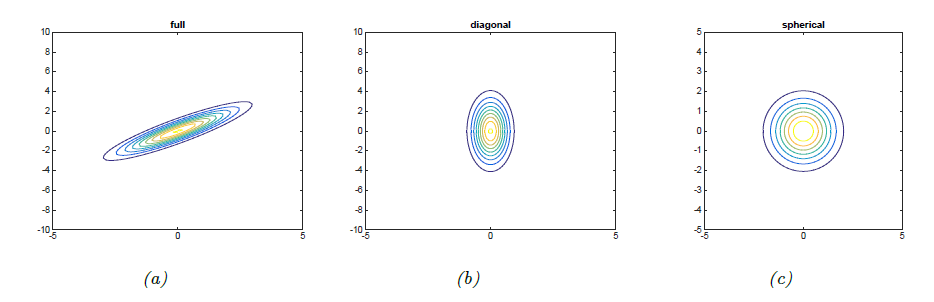

In [ ]:
def multivariate_gaussian_pdf(x, mean, covariance):
    """
    Calculate the multivariate Gaussian probability density function (PDF).

    Parameters:
    - x (numpy.ndarray): The input vector.
    - mean (numpy.ndarray): The mean vector.
    - covariance (numpy.ndarray): The covariance matrix.

    Returns:
    - float: The PDF value for the given input.
    """
    n = len(mean)

    # Ensure input dimensions match
    if len(x) != n or covariance.shape != (n, n):
        raise ValueError("Input dimensions do not match the mean and covariance matrix.")

    # Calculate the PDF
    exponent_term = -0.5 * np.dot(np.dot((x - mean).T, np.linalg.inv(covariance)), (x - mean))
    pdf = (1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(covariance) ** 0.5)) * np.exp(exponent_term)

    return pdf

# Mean vector and covariance matrix
mean = np.array([1.0, -0.5])
covariance = np.array([[1, -0.8], [-0.8, 1]])

# Generate grid points for x and y
x_values = np.linspace(-4, 4, 100)
y_values = np.linspace(-4, 4, 100)
x_mesh, y_mesh = np.meshgrid(x_values, y_values)
grid_points = np.column_stack((x_mesh.ravel(), y_mesh.ravel()))

# Calculate PDF values for each grid point
pdf_values = np.array([multivariate_gaussian_pdf(point, mean, covariance) for point in grid_points])

# Reshape PDF values to match the shape of the meshgrid
pdf_values = pdf_values.reshape(x_mesh.shape)

# Create a 3D surface plot
fig = go.Figure(data=[go.Surface(x=x_mesh, y=y_mesh, z=pdf_values, colorscale='Viridis')])

fig.update_layout(
    scene=dict(
        xaxis_title='x_1',
        yaxis_title='x_2',
        zaxis_title='p(x)',
    ),
    title='Multivariate Gaussian Distribution',
)

# Show the plot
fig.show()

Try to play around a bit with the mean vector and covariance matrix, to see how the multivariate normal distribution changes.

## Mixture distributions

We can also have joint distributions that mix discrete and continuous variables. For example, we may have two variables:

- $X$, a discrete variable that indicates whether you are male (0) or female (1)
- $Y$, a continuous variable that indicates your height.

In the Netherlands there are in total slightly less males than females, so let's assume:

- $p(X=0)=0.49$
- $p(X=1)=0.51$

The length statistics for the Netherlands have an average male length of 183cm and average female length of 169cm. Let's assume these are normally distributed with some made up standard deviation (where $\mathcal{N}$ stands for the pdf of the normal distribution):

- $p(Y|X=0) = \mathcal{N}(Y|\mu=180,\sigma=5)$
- $p(Y|X=1) = \mathcal{N}(Y|\mu=170,\sigma=4)$

Now we can actually compute the marginal probability distribution of height in the Netherlands, which becomes:

\begin{align} p(Y) &= \sum_X p(X,Y) = \sum_X P(X) \cdot P(Y|X)  \\
 &= 0.49 \cdot \mathcal{N}(Y|\mu=180,\sigma=10) + 0.51 \cdot \mathcal{N}(Y|\mu=170,\sigma=8)\
 \end{align}

We call this a [**Gaussian mixture distribution**](https://en.wikipedia.org/wiki/Mixture_model): it is a mixture of multiple Gaussian distributions, where each have their own probability/contributions according to some discrete random variable. Below we plot the above example, where we can clearly see the two bumps of the Gaussian distribution that together form the mixture.

In [ ]:
def p_y_normal(y,mu=0.0,sigma=1.0):
  return (1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((y-mu)/sigma)**2))

p_x0 = 0.49
p_x1 = 0.51
sample_space_y_range = np.arange(150,200,0.1) # bounded interval for plotting but technically the sample space is the whole real line
p_y_range_0 = p_y_normal(sample_space_y_range,mu=182,sigma=5.0)
p_y_range_1 = p_y_normal(sample_space_y_range,mu=169,sigma=4.0)

p_y = p_x0 * p_y_range_0 + p_x1 * p_y_range_1

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=sample_space_y_range, y=p_y, mode='lines', name='height'))

fig.update_layout(
    title='Example probability density function (pdf) of Gaussian mixture model',
    xaxis=dict(title='height (cm)', range=[150, 200]),
    yaxis=dict(title='p(height)', range=[0, 0.2]),
)
fig.show()

Mixture distributions are a simple way to model [*multi-modality*](https://en.wikipedia.org/wiki/Multimodal_distribution): distributions with multiple 'peaks' in the probability density function.

# 5. Expectation

Given a particular probability distribution we are in many cases interested in its *expectation*. The expectation is the *average* outcome of the distribution, i.e., if we take a sample from this distribution, what value do we expect to get out on average. This is an important notion, for example because we want to choose the action with the best average outcome.

Formally, the expectation of a discrete random variable $X$ with distribution $p(X)$ is defined as:

$$ \mathbb{E}_{x \sim p(x)}[x] = \sum_x p(x) \cdot x $$

The notation $\mathbb{E}$ stand for expectation, and the subscript $x \sim p(x)$ means the expectation runs over variable $x$ with distribution $p(x)$. Therefore, the whole expression $\mathbb{E}_{x \sim p(x)}[x]$ says that we want to compute the value of x, but we want to average over the uncertainty in $p(x)$. Sometimes we write $\mu$ ('mean') for the expectation of a distribution.

For the discrete case, we may compute the expectation by summing over the sample space, and reweighting each term by its probability. This gives us the expression on the right-hand side of the equation.



## Example

Imagine we have a lottery ticket with which we may either win nothing (99% chance), win 100 euro (0.9% chance) or win 10.000 euro (0.1% chance). What is the average amount of money we expect to win per round when we play a ticket in this lottery? Let's compute it below:

In [ ]:
def discrete_expectation(x_sample_space, p_x):
  '''
  The discrete_expectation function calculates the expected value (or mean) of a discrete random variable given its sample space and corresponding probabilities.

  Parameters:
  - x_sample_space (numpy array): An array representing the sample space of the discrete random variable. It contains all possible values that the random variable can take.
  - p_x (numpy array): An array representing the probabilities associated with each value in the sample space. The probabilities must be in the same order as the values in x_sample_space.

  Returns:
  - E_x (float): The expected value of the discrete random variable.
  '''

  E_x = np.sum(x_sample_space*p_x)
  return E_x

x_sample_space = np.array([0,100,10000]) # Possible lottery outcomes
p_x = np.array([0.99,0.009,0.001]) # Associated probabilities
E_x = discrete_expectation(x_sample_space,p_x)
print('Expectation/average of x under distribution p(x):\nE[x]=', E_x)

E_x = np.matmul(x_sample_space,p_x) # Other option using the inner product between the sample space and the associated probabilities
print('E[x]=', E_x)

Expectation/average of x under distribution p(x):
E[x]= 10.9
E[x]= 10.9


The average win per ticket is therefore 10.9 euros. As you can see, we will never actually win 10.9 euro in a single round, since the only options are 0, 100 or 10000 euro. But if we would play infinitely many times, then the average over all rounds would be 10.9. The expectation therefore tells us what we expect to get on average, but it does not tell us how large the spread around that mean is.

## Expectation of a function

We can also compute the expectation of an arbitrary function $f$ of $x$, which simply becomes:

$$ \mathbb{E}_{x \sim p(x)}[f(x)] = \sum_x p(x) \cdot f(x) $$

Example: Imagine we don't actually directly get the money, but we still need to pay tax. Therefore, we only get the **square root** of the won amount (yes, interesting taxation system). What is our new expected win or loss?

In [ ]:
def f(x):
  return np.sqrt(x)

E_sqrt_x = discrete_expectation(f(x_sample_space),p_x)
print('Expectation/average of sqrt(x) under distribution p(x):\nE[sqrt(x)]=', E_sqrt_x)

print('Note that this is not the same as taking the square root after the expectation E[x]!')
print('sqrt(E[x])=',np.sqrt(E_x))

Expectation/average of sqrt(x) under distribution p(x):
E[sqrt(x)]= 0.19
Note that this is not the same as taking the square root after the expectation E[x]!
sqrt(E[x])= 3.3015148038438356


With the square root taxation of our win we now only expect to win 0.19 euro on average (the square root is of course a very heavy taxation). In the last line you can see that the expectation of a function of a random variable is not equal to the function of the expectation (important to avoid this mistake).  

## Expectation of categorical variables

The above calculations of expectation only work if the values of x actually mean something relative to eachother, i.e., if the are on and **ordinal** (or continuous) scale. In our example, all pay-offs are on the same euro scale, and there relative values can therefore be averaged.

However, often we are also interested in true categorical variables, such as classifying whether an image shows a cat, dog or rabbit. In this case, the sample space is ```['cat','dog', 'rabbit']```. In you computer you could for example transfer these into indices ```[0,1,2]``` (to store/refer to them).

However, imagine these classes have probabilities ```[0.1,0.3,0.6]```. In this case it does **not** make sense to compute the expectation as $(0.1 \cdot 0) + (0.3 \cdot 1) + (0.6 \cdot 2) = 1.5$. The point is that the numbers assigned to these categories are completely arbitrary: we could just as wel have given the label '0' to 'rabbit'. The average of 1.5 therefore does not have any meaning.

A categorical variable should therefore really be represented in memory as a one-hot vector, since all categories are simply disjoint:
- 'cat' = ```[1,0,0]```
- 'dog' = ```[0,1,0]```
- 'rabbit' = ```[0,0,1]```

(often we do store the categorical variable as indices, e.g. ```[0,1,2]``` in this case, as long as you remember that these numbers underneath really index into a one-hot vector, and should not be treated according to the numeric index value)

Now we can compute the correct expectation:

In [ ]:
y_labels = ['cat','dog','rabbit']
y_sample_space = np.array([[1,0,0],[0,1,0],[0,0,1]])
p_y = np.array([0.1,0.3,0.6])
E_y = np.sum(p_y * y_sample_space,axis=1)
print(E_y)

[0.1 0.3 0.6]


As you can see, the expectation is just equal to the vector of probabilities (which makes sense, because on average we expect to get a rabbit in 60% of cases, so the third element of our one-hot vector should indeed be equal to 0.6).

Of course, we might have a function of the categorical variable that does end up on a numeric scale again. Maybe we want to compute the monthly cost for food per animal, in which case f(x) would map each category to a real number, and we can compute the expectation as a single number.



# 6. Variance

The mean/expectation tells us what we on average expect to get when we sample from a distribution, but it does not tell us how much variation we might expect in such a sample. Will we always get the exact expectation, or will we sometimes get much more, and at other times much less? To characterize this property we need to define the **variance** of a distribution. The variance measures the average squared distance of a sample from its mean: the higher the chance we are far off, the higher the variance. We can write this as (where all expectations run over variable $X$):  

$$ Var(X) = \mathbb{E} [ (X - \mathbb{E} [X])^2 ] $$

Because the variance is the squared deviation from the mean, we may take the square root to get a better interpretable metric: the **standard deviation**, usually denoted by sigma:

$$ \sigma(X) = \sqrt{Var(X)} $$

Let's compute the variance and standard deviation of our lottery example:





In [ ]:
x = np.array([0,100,10000]) # Possible lottery outcomes
p_x = np.array([0.99,0.009,0.001]) # Associated probabilities
E_x = mu = np.sum(p_x * x)
Var_x = np.sum(p_x * (x - mu)**2)
std_x = np.sqrt(Var_x)
print('sample space', x)
print('p(x)=', p_x)
print('E[x]=', E_x)
print('Var(x)=', Var_x)
print('Std(x)=', std_x)

sample space [    0   100 10000]
p(x)= [0.99  0.009 0.001]
E[x]= 10.9
Var(x)= 99971.19
Std(x)= 316.1822101257438


This implies we expect to earn 10.9 euro from the lottery, but the standard deviation around that estimate is 316.2 euro. This correctly indicates that the spread is quite large: sometimes we actually get much more.

##Covariance

We can also capture the variance between two distributions, known as the *covariance*. The covariance measures the extend of the linear relation between both variables

- If $X$ on average goes up when $Y$ goes up, then we have a positive covariance.
- If $X$ on average goes down when $Y$ goes up, then we have a negative covariance.
- If $X$ on average goes up just as much as it goes down when $Y$ goes up, then the covariance is zero.

In equations, we can express this as:

$$ Cov(x,y) = \mathbb{E}_{x,y}[ (x - \mathbb{E}_{x}[x]) \cdot (y - \mathbb{E}_{y}[y])  ] $$

See below for an example for two binary 0/1 variables. Play around a bit with the joint distribution to verify how the covariance changes for each setting:

In [ ]:
def cov_discrete(p_xy, x = np.array([0,1]), y = np.array([0,1])):
  n_x, n_y = p_xy.shape
  p_x = np.sum(p_xy,axis=1)
  p_y = np.sum(p_xy,axis=0)
  E_x = np.sum(p_x * x)
  E_y = np.sum(p_y * y)
  diff_x = np.repeat((x - E_x)[:,None],n_x,axis=1)
  diff_y = np.repeat((y - E_y)[None,:],n_y,axis=0)
  cov_xy = np.sum(p_xy * diff_x * diff_y)
  return cov_xy

x = np.array([0,1])
y = np.array([0,1])
p_xy = np.array([[0.5,0.0],[0.0,0.5]])
cov_xy = cov_discrete(p_xy, x, y)
print('p(x,y)=\n', p_xy, '\nCov(x,y)=',cov_xy)

p_xy = np.array([[0.0,0.5],[0.5,0.0]])
cov_xy = cov_discrete(p_xy, x, y)
print('\n\np(x,y)=\n', p_xy, '\nCov(x,y)=',cov_xy)

p_xy = np.array([[0.25,0.25],[0.25,0.25]])
cov_xy = cov_discrete(p_xy, x, y)
print('\n\np(x,y)=\n', p_xy, '\nCov(x,y)=',cov_xy)

p_xy = np.array([[0.1,0.1],[0.4,0.4]])
cov_xy = cov_discrete(p_xy, x, y)
print('\n\np(x,y)=\n', p_xy, '\nCov(x,y)=',cov_xy)


p(x,y)=
 [[0.5 0. ]
 [0.  0.5]] 
Cov(x,y)= 0.25


p(x,y)=
 [[0.  0.5]
 [0.5 0. ]] 
Cov(x,y)= -0.25


p(x,y)=
 [[0.25 0.25]
 [0.25 0.25]] 
Cov(x,y)= 0.0


p(x,y)=
 [[0.1 0.1]
 [0.4 0.4]] 
Cov(x,y)= 0.0


Note that the covariance measures the amount of *linear* relationship between $X$ and $Y$. If the covariance is 0, then there is on average no linear relationship, but there might still be another non-linear relation between them. For example, in the image below:

- The distribution in the left figure has **large covariance** (linear relation): whenever x goes up, y also goes up.
- However, the distribution in the right figure has **no covariance**: when x goes up, y on average goes up as much as it goes down. However, we can clearly see there is a strong non-linear relation between both variables (which the covariance does not capture). Therefore, always watch out with interpreting covariance (and correlation) statistics, since there might be a non-linear relation hiding underneath.

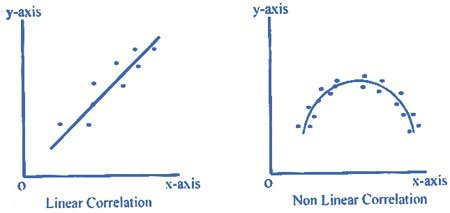

# 7. Entropy

Another important property of a distribution is its **entropy**. The entropy of a distribution is a measure of its overall uncertainty: the more uncertainty we have about the outcome, the higher the entropy. Formally, the entropy $H$ is defined as the expectation of the negative log of $p(x)$:

$$ H[x] = \mathbb{E}_{x \sim p(x)} [ - \log p(x) ]$$

For a discrete variable, we can write this out as

$$ H[x] = - \sum p(x) \cdot \log p(x) $$

Below we compute the entropy of our earlier distribution over football match points of `[0.2,0.3,0.5]`, and compare it to a distribution where we always win our match and get three points `[0.0,0.0,1.0]`.

In [ ]:
def discrete_entropy(p_x):
  log_p_x = np.log(np.array(p_x)+1e-30) # add a small constant before the log to prevent NaNs for log(0)
  H_x = np.sum(p_x * -log_p_x)
  return H_x

p_x = [0.2, 0.3, 0.5]
H_x = discrete_entropy(p_x)
print('p(x)=', p_x, '-->  H[x]=',np.round(H_x,3))

p_x = [0.0, 0.0, 1.0]
H_x = discrete_entropy(p_x)
print('p(x)=', p_x, '-->  H[x]=',np.round(H_x,3))

p(x)= [0.2, 0.3, 0.5] -->  H[x]= 1.03
p(x)= [0.0, 0.0, 1.0] -->  H[x]= 0.0


As you can see, the entropy of our first distribution is clearly higher, since we are relatively uncertain about the outcome. In the second case, when we are certain we will win the match, the entropy of the distribution is actually 0.0, since we have no uncertainty at all.

We can gain better insight into the entropy by looking at a binary 0/1 variable (a Bernouilli variable). For such variables, we can characterize the distribution with only one parameter. For example, if we define $p(x=0)$, the chance that $x$ is equal to 0, then we automatically know that $$p(x=1) = 1.0 - p(x=0),$$ due to the constraint the full distribution needs to sum to 1.0. Therefore, we can vary the value of $p(x=0)$, and plot what the effect is on the entropy $H[x]$ of the whole distribution:

In [ ]:
import plotly.graph_objects as go

p_x0s = np.arange(0,1.01,0.01) # Define a range of p(x=0) for a binary variable
H_xs = [discrete_entropy([p_x0,1-p_x0]) for p_x0 in p_x0s] # Compute the entropy of the distribution

fig = go.Figure()
fig.add_trace(go.Scatter(x=p_x0s, y=H_xs, mode='lines', name='Entropy'))
fig.update_layout(
    title='Entropy of Binary variable',
    xaxis=dict(title='p(x=0)', range=[0, 1]),
    yaxis=dict(title='H[x]', range=[0, 1]),
)
fig.show()

We can clearly see that the entropy is 0.0 when either `p(x=0)=0.0` or `p(x=0)=1.0`. In these case, we have no uncertainty about the value of x, and the entropy is therefore also 0.0. We also see the entropy is highest when `p(x=0.5)`, i.e, when we have the highest uncertainty whether `x` will be 0 or 1.

## Cross-entropy

We can also define the **cross-entropy** between two distributions, which is often used as a loss function in classification tasks. If we have two distributions over the same sample space, e.g., $p(x)$ and $q(x)$, then the cross entropy is defined as:

$$ H[p(x),q(x)] = \mathbb{E}_{x \sim p(x)} [ - \log q(x) ]$$

For a discrete variable, we can write this out as:

$$ H[p(x),q(x)] = - \sum p(x) \cdot \log q(x) $$

The intuition of the cross-entropy is that it is smallest when both distributions are equal, i.e., when $p(x) = q(x)$. Therefore, in classification tasks we often minimize the cross-entropy between the observed data distributions $p(x)$ and the probability of that data under the learned model $q(x)$.

Below we illustrate the cross-entropy between two binary variable distributions, where we vary $q(x)$ on the x-axis against two possible situations for $p$, being $p(x) = [1.0,0.0]$ and $p(x) = [0.5,0.5]$. The main takeaway is that the cross-entropy between two distributions is lowest when they exactly align (are equal).


In [ ]:
def discrete_cross_entropy(p_x,q_x):
  log_q_x = np.log(np.array(q_x)+1e-10) # add a small constant before the log to prevent NaNs for log(0)
  H_x = np.sum(p_x * -log_q_x)
  return H_x


import plotly.graph_objects as go

p_x0s = np.arange(0,1.01,0.001) # Define a range of p(x=0) for a binary variable
H_xs0 = [discrete_cross_entropy([1.0,0.0],[p_x0,1-p_x0]) for p_x0 in p_x0s] # Compute the entropy of the distribution
H_xs1 = [discrete_cross_entropy([0.5,0.5],[p_x0,1-p_x0]) for p_x0 in p_x0s] # Compute the entropy of the distribution

fig = go.Figure()
fig.add_trace(go.Scatter(x=p_x0s, y=H_xs0, mode='lines', name='$p(x)=[1.0,0.0]$'))
fig.add_trace(go.Scatter(x=p_x0s, y=H_xs1, mode='lines', name='$p(x)=[0.5,0.5]$'))
fig.update_layout(
    title='Cross-entropy H[p(x),q(x)] for variations in binary q(x) (x-axis) and binary p(x) (different lines)',
    xaxis=dict(title='q(x=0)', range=[0, 1]),
    yaxis=dict(title='H[p(x),q(x)]', range=[0, 5]),
)
fig.show()

<ipython-input-29-f629ff74f963>:2: RuntimeWarning:

invalid value encountered in log



- The blue line computes the entropy with respect to $p(x) = [1.0,0.0]$. We can clearly see the entropy is lowest when $q(x=0)=1.0$, i.e., when $q(x) = [1.0,0.0]$, and both distributions are therefore the same.
- The red lines changes to $p(x)=[0.5,0.5]$. Now we see the minimum cross-entropy is achieved when $q(x)=[0.5,0.5]$, i.e., again when we match both distributions.

# 8. Predicting a distribution with a neural network

Quite often you want to predict a conditional distribution, for example $p(y|x)$ in a classification problem or $\pi(a|s)$ in a reinforcement learning task. You feed the input $x$ or $s$ into a neural network, but how do you predict the conditional distribution at output level?

The solution is to let the network predict the parameters of the distribution you want. You therefore mostly need to ensure that you: 1) predict the right number of parameters, and 2) ensure that are in the right range (e.g., the standard deviation of a Normal distribution should always be positive). We will give an example for both the discrete and continuous cases.



## Predicting discrete distributions

For a discrete output distribution you let your network first predict a vector of *logits* $z_i \in \mathbb{R}$ for each class $i$. Each logit is an unnormalized log-probability for its associated category $i$. For example, if we need to predict a distribution over 4 possible categories, then we predict a vector of length 4, e.g., `z = [2.5, 3.2,-1.3,0.0]`. Each of these entries is a real number. To turn this into a distribution we first exponentiate every element (to make it positive), and then divide it over the sum of the vector (to normalize it into a distribution, i.e., make it sum to 1.0). This is known as the *softmax* function, which computes the probability of class $y_i$ given logits vector $z$ as:

$$ p(y_i) = \frac{e^{z_i}}{\sum_j e^{z_j}} $$

Let's look at an example:

In [ ]:
def softmax(z):
  return np.exp(z)/np.sum(np.exp(z))

logits = z = np.array([2.5, 3.2,-1.3,0.0]) # logits = z = some_neural_network(x)
p_y = softmax(logits)
print('Logits=',z)
print('p(x)=',np.round(p_y,3))


Logits= [ 2.5  3.2 -1.3  0. ]
p(x)= [0.321 0.646 0.007 0.026]


- You can see that `p_y` has become a valid discrete distribution that sums to 1.0. For example, the predicted probability that $y$ is equal to 1 is 64.6% (remember indexing starts at 0).
- The higher the logit of a certain class, the higher the probability of that class after the softmax as well. This is where the name 'softmax' originates from: your are maximizing, but in a soft (and differentiable) way, assigning most probability to the highest element of the vector.
- Never actually use the above softmax implementation in practice, since it is numerically unstable. If you put larger numbers into `np.exp`, then you will quickly get a `NaN`. The solution is to first substract the maximum logit value from all logits, which will not change the outcome, but will prevent you are exponentiating a too large number. Google around to find some examples. In practice it's best to use the softmax implementation of a software package, which should have a stable implementation.  
- You can also introduce a **temperature** parameter into the softmax. By scaling the temperature parameter you can make the softmax more or less greedy. Again Google around if you want to see some examples.

## Predicting continuous distributions

We follow the same recipe for predicting a continuous distribution. If we for example want to predict a 1D Gaussian, then we let our network first predict two real numbers $z_i \in \mathbb{R}$ (without any non-linearity):

- The first of these numbers is the predicted mean, which is unrestricted.
- The second of these numbers is the standard deviation, which should be positive to make it a valid probability distribution. We can ensure this by for example exponentiating the output, which guarantees the number is positive (or use any other preferred function, such as the [**softplus**](https://paperswithcode.com/method/softplus)).

Below you can find an example:

In [ ]:
# Predicting a 1D Gaussian
z = np.array([-2.2, -0.7]) # z = some_neural_network(x)
mu = z[0]
sigma = np.exp(z[1]) # or sigma = softplus(z[1])
print('1D Gaussian\nNetwork prediction z=',z)
print('mu =',mu)
print('sigma =',np.round(sigma,3))

1D Gaussian
Network prediction z= [-2.2 -0.7]
mu = -2.2
sigma = 0.497


Now imagine we need to predict a 2D Gaussian. In theory we would need to predict 5 variables: 2 for the means, and three for the covariance matrix (since the off-diagonal elements are symmetric). However, we will assume here the covariance matrix is diagonal (no covariance between both variables), in which case we only need 4 numbers:

In [ ]:
# Predicting a 2D independent Gaussian (without covariance)
z = np.array([-2.2, -0.7, 1.3, 0.3]) # z = some_neural_network(x)
mu = z[:2]
sigma = np.exp(z[2:]) # or sigma = softplus(z[1])
print('\n2D Gaussian\nNetwork prediction z=',z)
print('mu =',mu)
print('sigma =',np.round(sigma,3))


2D Gaussian
Network prediction z= [-2.2 -0.7  1.3  0.3]
mu = [-2.2 -0.7]
sigma = [3.669 1.35 ]


# 9. Conclusion

In short, this notebook introduced the key concepts in probability theory. We saw:

- How to define a discrete and continuous distribution (sample space, pmf/pdf, cdf).
- Some examples of common parametrized distributions, such as the Categorical and Bernouilli for the discrete case, and the Normal and Uniform for the continuous case. There is a long list of possible [parametrized distributions](https://en.wikipedia.org/wiki/List_of_probability_distributions).
- How to sample from a given distribution in a computer (using pseudo-randomness in the random number generator).
- How to define distributions over multiple variables (joint distributions).
- How to manipulate between joint, marginal and conditional distributions, and the notion of independent distributions.
- How to compute the expectation/average of a distribution.
- How to compute the variance/spread of a distribution.
- How to compute the entropy/uncertainty of a distribution.
- How to predict a preferred distribution as output of a neural network.